# Food101 Project

In this Food101 Project, we will be using the Food101 dataset to create an image classification system to classify 101 different types of food. This project is a notebook before turning it into an application or website. This notebook is divided into the following:

1. Preparation for Food101 Projects
2. Exploring the dataset
3. Preprocessing the dataset
4. Create modelling callbacks
5. Setup Mixed Precision Training
6. Build Feature Extraction Model
7. Fit the feature extraction model and Evaluate
8. Fine-Tune your feature extraction model to beat the [DeepFood Paper](https://arxiv.org/pdf/1606.05675)
9. Evaluate the model result on TensorBoard
10. Evaluate the model by making and plotting predictions

## 1. Setting for Food101 Projects

- We will see whether the GPU is enabled for the TensorFlow to be used.
- We will download necessary helper function made beforehand.
- We will bring the Food101 dataset.

In [1]:
# Check if TensorFlow can access the GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:", gpus)
else:
    print("No GPU detected. Using CPU.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import helper functions
from helper.helper import plot_loss_curves, start_tensorboard_callback, compare_history

# Download the dataset of Food101
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir="/Users/junyoung/Documents/Food101/dataset"
)

/opt/anaconda3/envs/food101_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-15 17:09:39.061287: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-15 17:09:39.061322: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-15 17:09:39.061328: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-15 17:09:39.061348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 17:09:39.061362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB mem

## 2. Exploring the Food101 dataset
- Class names
- Shape of our input data 
- The datatype of our input data
- How the labels look like
- Do the labels match with the class names?
- Look into an image from the dataset

In [3]:
# Get the features of the dataset directory
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [4]:
# Get the class names
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [5]:
# Take one sample fo the train data
train_one_sample = train_data.take(1)

# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 1
    Class name (str form): baby_back_ribs
    


2025-04-15 17:09:41.170224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


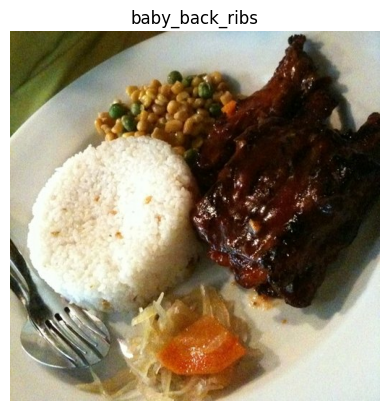

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## 3. Preprocessing the dataset
- Conver the data type of the image
- Shape the image

In [7]:
def preprocessing_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' --> 'float32' and reshapes
    image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [8]:
# Preprocess a single sample image and check the output
preprocessed_img = preprocessing_img(image, label)[0]
print(f"Image before preprocessing:\n{image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {image.dtype}\n")

Image before preprocessing:
[[[ 95  95  25]
  [ 87  87  17]
  [ 96  93  26]
  ...
  [178 189 191]
  [180 191 193]
  [178 189 191]]

 [[ 92  92  22]
  [ 86  86  16]
  [ 91  88  21]
  ...
  [183 194 196]
  [184 195 197]
  [180 191 193]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 88.755104  88.755104  18.755102]
  [ 88.341835  85.341835  18.341835]
  [ 86.377556  81.16327   17.591837]
  ...
  [182.5153   193.5153   195.5153  ]
  [181.47958  192.47958  194.47958 ]
  [181.39784  192.39784  194.39784 ]]

 [[ 96.57143   93.57143   24.571428]
  [ 92.38265   89.38265   22.382656]
  [ 93.72959   88.515305  24.94388 ]
  ...
  [189.42863  200.42863  202.42863 ]
  [189.78568  200.78568  202.78568 ]
  [183.90295  197.90295  198.90295 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'uint8'>



In [9]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


## 4. Create modelling callbacks

- Create TensorBoard Callback ==> log training results
- Create ModelCheckpoint Callback ==> save our model's progress after feature extraction

In [11]:
# create tensorboard callback
from helper.helper import start_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## 5. Setup Mixed Precision Training
- Mixed precision training is a technique used in deep learning to accelerate training speed and reduce memory usage by using both 16-bit and 32-bit floating-point numbers to represent the weights and activations in a neural network.

In [12]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print(mixed_precision.global_policy())

<DTypePolicy "mixed_float16">


## 6. Build Feature Extraction Model

In [13]:
from tensorflow.keras import layers

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [14]:
# Getting model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
for layer in model.layers:
    print(f"{layer.name}, {layer.trainable}, {layer.dtype} {layer.dtype_policy}")

input_layer, True, float32 <DTypePolicy "mixed_float16">
efficientnetb0, False, float32 <DTypePolicy "mixed_float16">
global_average_pooling2d, True, float32 <DTypePolicy "mixed_float16">
dense, True, float32 <DTypePolicy "mixed_float16">
softmax_float32, True, float32 <DTypePolicy "float32">


## 7. Fit the feature extraction model and Evaluate

In [16]:
# Fit the feature extraction model wil callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[start_tensorboard_callback(dir_name="training_logs",
                                                                                           experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving the TensorBoard log files into: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250415-171000
Epoch 1/3


2025-04-15 17:10:02.440296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 586s 245ms/step - accuracy: 0.4754 - loss: 2.2913 - val_accuracy: 0.7010 - val_loss: 1.1391
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 614s 259ms/step - accuracy: 0.6671 - loss: 1.2946 - val_accuracy: 0.7238 - val_loss: 1.0215
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 566s 239ms/step - accuracy: 0.7030 - loss: 1.1354 - val_accuracy: 0.7275 - val_loss: 1.0025


In [17]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 164s 207ms/step - accuracy: 0.7259 - loss: 1.0077


[1.004292368888855, 0.7269703149795532]

## 8. Fine-Tune your feature extraction model

In [15]:
# Unfreeze the layer
for layer in model.layers:
    layer.trainable = True

# Check the datatype and whether they are trainable
for layer in model.layers:
    print(f"{layer.name} is trainable: {layer.trainable}, dtype: {layer.dtype}")

input_layer is trainable: True, dtype: float32
efficientnetb0 is trainable: True, dtype: float32
global_average_pooling2d is trainable: True, dtype: float32
dense is trainable: True, dtype: float32
softmax_float32 is trainable: True, dtype: float32


In [16]:
# Setup earlystopping
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience=3)

# Create model checkpoint
checkpoint_path = "finetune_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [17]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [18]:
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [19]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[start_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   earlystopping_callback, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving the TensorBoard log files into: training_logs/efficientb0_101_classes_all_data_fine_tuning/20250402-003043
Epoch 1/100


2025-04-02 00:30:56.582480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3597s 1s/step - accuracy: 0.3506 - loss: 2.9474 - val_accuracy: 0.7262 - val_loss: 1.0126 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3543s 1s/step - accuracy: 0.6716 - loss: 1.2694 - val_accuracy: 0.7648 - val_loss: 0.8672 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4249s 2s/step - accuracy: 0.7234 - loss: 1.0435 - val_accuracy: 0.7693 - val_loss: 0.8191 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 12530s 5s/step - accuracy: 0.7553 - loss: 0.9050 - val_accuracy: 0.7712 - val_loss: 0.8389 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7785 - loss: 0.8165
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2701s 1s/step - accuracy: 0.7785 - loss: 0.8165 - val_accuracy: 0.7627 - val_loss: 0.8507 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 2859s 1s/s